In [1]:
import tensorflow as tf
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import os
import cv2
import math

import utils

mnist_path = 'data/mnist-zoomed-to-bounds.npy'
model_path = 'data/model'

2021-07-23 22:43:52.736551: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


deskew() Found angle: 0.0
3352
[[1228 2603 1303 2678]
 [1681 2542 1767 2627]
 [1632 2542 1765 2679]
 [1581 2542 1728 2679]
 [1532 2541 1679 2679]
 [1481 2541 1629 2679]
 [1355 2541 1505 2678]
 [1305 2541 1453 2677]
 [1255 2541 1403 2677]
 [1431 2540 1579 2679]
 [1229 2541 1378 2678]
 [1944 3109 1996 3152]
 [2225 3031 2262 3067]
 [1516 3038 1559 3070]
 [ 583 2865  627 2898]
 [ 229 2791  268 2834]
 [1518 2793 1560 2824]
 [ 605 2783  649 2824]
 [ 375 2768  421 2822]
 [ 872 2856  944 2941]
 [ 759 2558  804 2590]
 [1971 2565 2015 2609]
 [1875 2559 1920 2592]
 [1310 2334 1356 2367]
 [ 590 2324  647 2384]
 [1553 2019 1610 2079]
 [1524 1796 1566 1839]
 [1155 1795 1196 1838]
 [ 786 1795  828 1836]
 [1524 1750 1566 1791]
 [1154 1749 1196 1791]
 [ 786 1749  828 1790]
 [1524 1703 1566 1746]
 [ 786 1702  828 1745]
 [1525 1657 1566 1699]
 [1155 1656 1197 1697]
 [ 787 1656  828 1698]
 [2261 1798 2303 1840]
 [2261 1752 2302 1794]
 [2261 1705 2303 1747]
 [1894 1704 1934 1747]
 [ 419 1701  460 1744]
 [ 

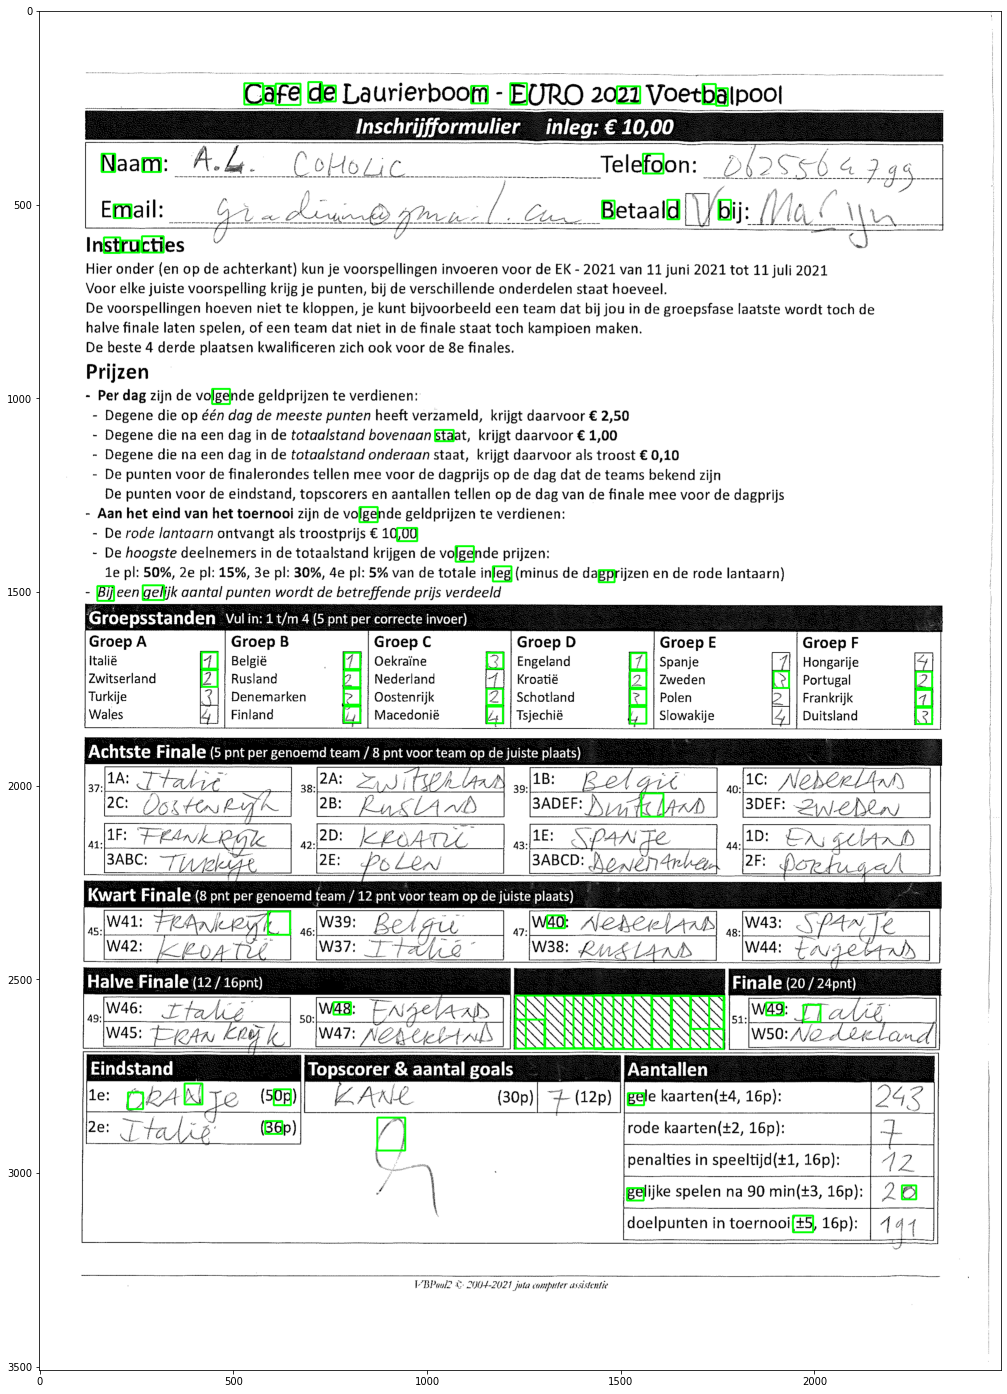

In [2]:
img = cv2.imread('/home/dan/Downloads/poulespng/poule-11.pdf.png', cv2.IMREAD_UNCHANGED)
img = utils.deskew(img, debug=True)

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
th, thresh = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
thresh = 255 - thresh

blur=cv2.GaussianBlur(thresh, (5, 5), 1)
# canny=cv2.Canny(blur, 5, 25)

contours, hierarchy = cv2.findContours(
    image=blur, 
    mode=cv2.RETR_TREE,
    method=cv2.CHAIN_APPROX_NONE
)
print(len(contours))

# This is too naive. One way to improve could be using width/height ratio to filter
# 1/1 would be square = group stage. 2/1 would be landscape rect = match entry, etc. 
filtered = []
for c in contours:
    o = 20
    area = cv2.contourArea(c)
    if area < 1000 or area > 5000: continue
    perimeter = cv2.arcLength(c, True)
    approximation = cv2.approxPolyDP(c, 0.02 * perimeter, True)
    if len(approximation) > 100: continue
    x, y, w, h = cv2.boundingRect(approximation)
    if w >= h + o or w <= h - o: continue
    filtered.append([x, y, x + w, y + h])

# Naive duplicate filtering... Is there a better openCV'nic way?
rects = []
for r in filtered:
    rel_tol = 0.02
    existing = [er for er in rects if math.isclose(r[0], er[0], rel_tol=rel_tol) and math.isclose(r[1], er[1], rel_tol=rel_tol)]
    if len(existing): continue
    rects.append(r)
    cv2.rectangle(img, (r[0], r[1]), (r[2], r[3]), (0, 255, 0), 3)

rects = np.asarray(rects)
    
# Sort from left to right top to bottom
# print('hai', rects[rects[:1].argsort()])
print(rects)
print(np.asarray(rects).shape)

thresh = np.asarray(thresh)
print(thresh.shape)

# thresh = thresh.reshape(*thresh.shape, 1)
thresh = np.expand_dims(thresh, axis=2)

thresh = thresh / 255

print(thresh.shape)

plt.figure(figsize=(25, 25))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
physical_devices

2021-07-23 22:43:56.870488: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-23 22:43:59.493216: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-07-23 22:43:59.493332: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (dell-taco): /proc/driver/nvidia/version does not exist


[]

In [4]:
# Use cached augmented data if it exists
if os.path.isfile(mnist_path) is False:
    print("Normalizing mnist data set")
    mnist = tf.keras.datasets.mnist

    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    x_train = x_train / 255.0
    x_test  = x_test  / 255.0
    
    x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
    x_test  = x_test.reshape(x_test.shape[0], 28, 28, 1)

    x_train = np.array([utils.zoom_to_bounds(img_array) for img_array in x_train])
    x_test  = np.array([utils.zoom_to_bounds(img_array) for img_array in x_test])

    to_save =  np.array( ([x_train, y_train], [x_test, y_test]) )
    np.save(mnist_path, to_save)
else:
    print("Using cached mnist data set")
    (x_train, y_train), (x_test, y_test) = np.load(mnist_path, allow_pickle=True)

Using cached mnist data set


In [5]:
# Not overwriting if already exists!
if os.path.isdir(model_path) is False:
    print("Training model")
    model = tf.keras.models.Sequential([
      tf.keras.layers.Flatten(input_shape=(28, 28)),
      tf.keras.layers.Dense(128, activation='relu'),
      tf.keras.layers.Dropout(0.2),
      tf.keras.layers.Dense(10)
    ])
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=12)
    model.save(model_path)
else:
    print("Loading cached model")
    model = tf.keras.models.load_model(model_path)
    
model.evaluate(x_test,  y_test, verbose=2)

2021-07-23 22:43:59.647619: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading cached model


2021-07-23 22:43:59.848998: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2021-07-23 22:43:59.867175: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2199995000 Hz


313/313 - 0s - loss: 0.0782 - accuracy: 0.9773


[0.07823777198791504, 0.9772999882698059]

In [6]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [7]:
pngs = sorted(glob("data/pngs/*.png"))
def load_image(path):
    image     = tf.keras.preprocessing.image.load_img(path, color_mode="grayscale", target_size=(28,28), interpolation='nearest')
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    return input_arr / 255

actual_data = [load_image(png) for png in pngs]
actual_data = np.array(actual_data)
actual_data.shape

(52, 28, 28, 1)

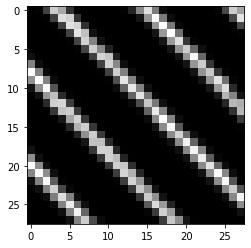

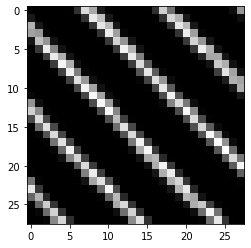

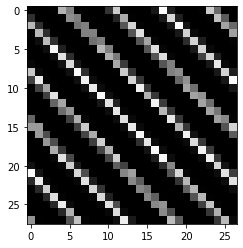

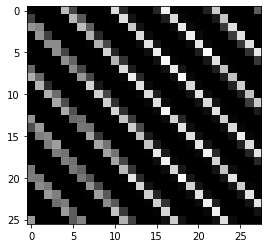

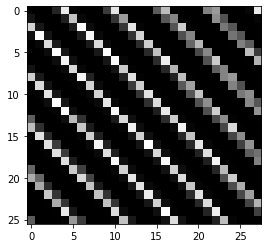

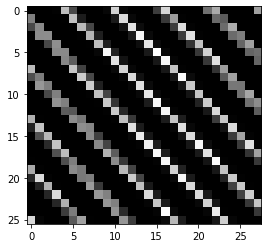

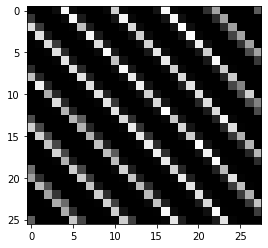

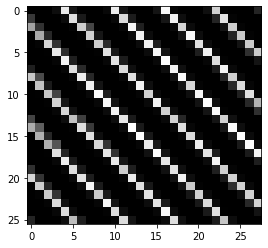

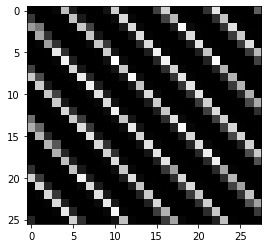

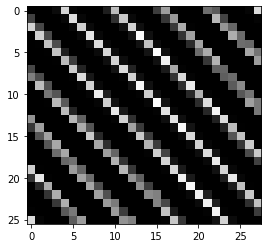

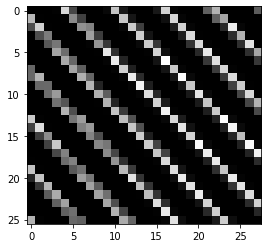

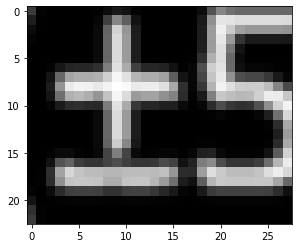

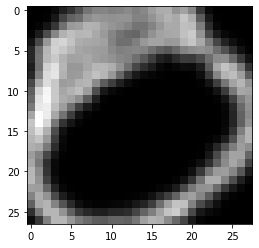

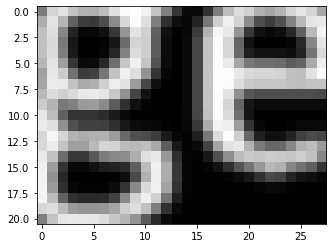

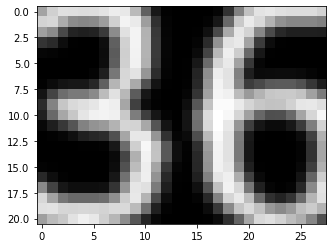

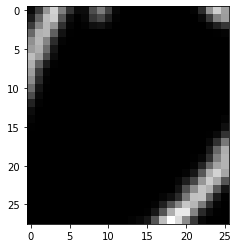

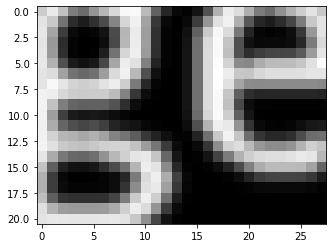

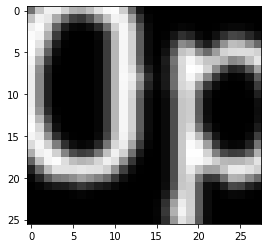

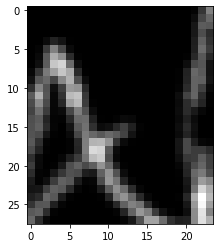

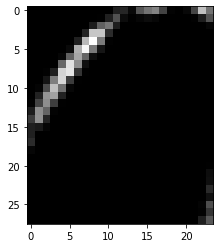

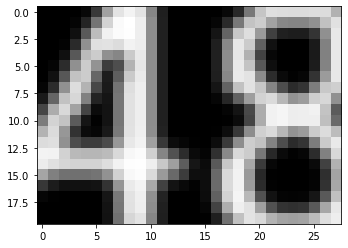

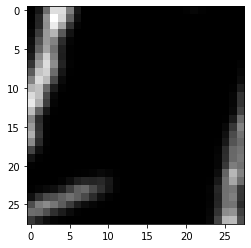

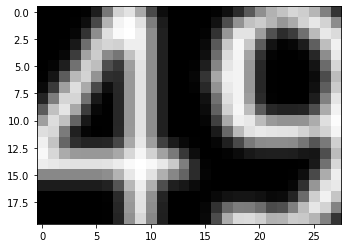

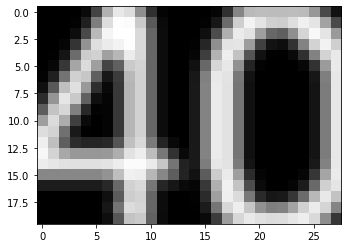

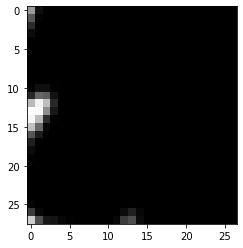

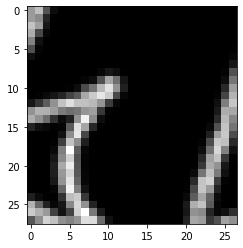

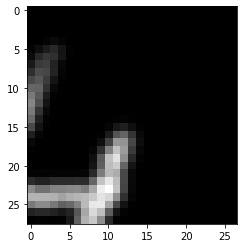

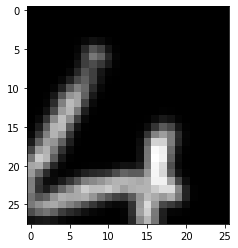

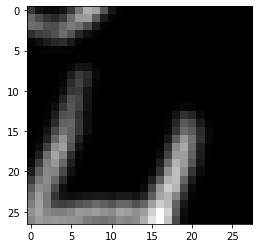

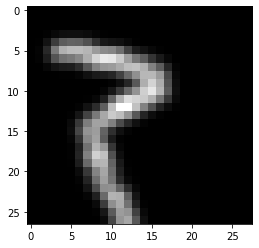

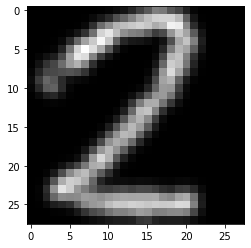

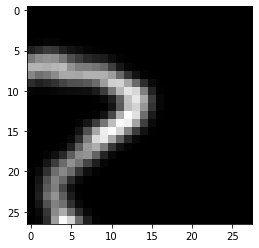

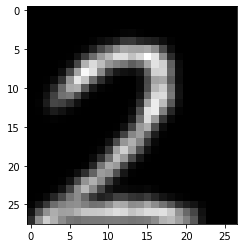

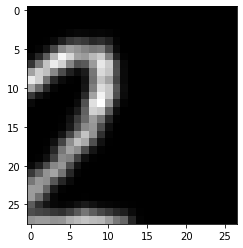

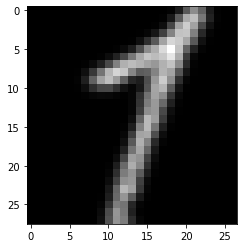

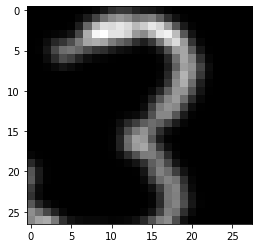

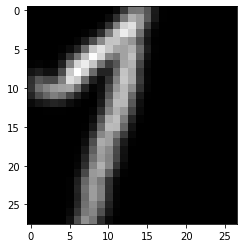

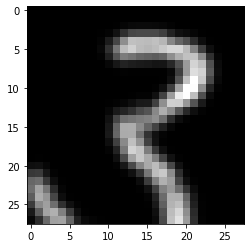

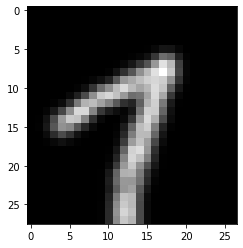

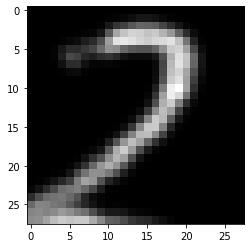

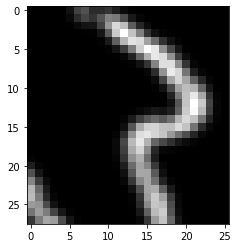

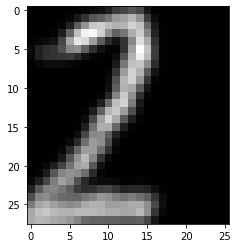

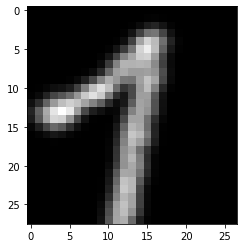

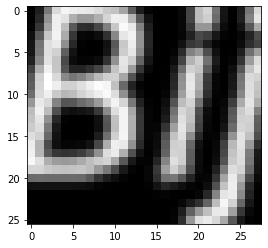

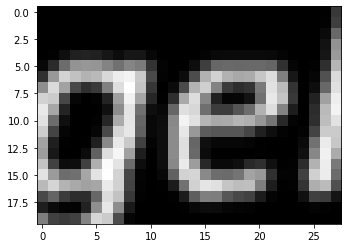

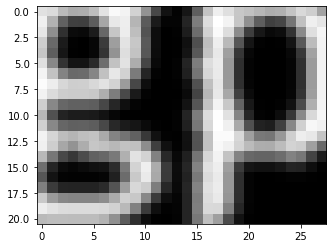

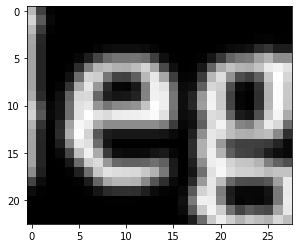

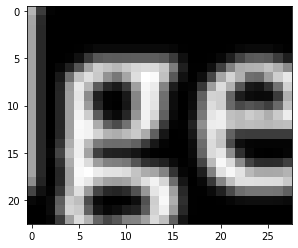

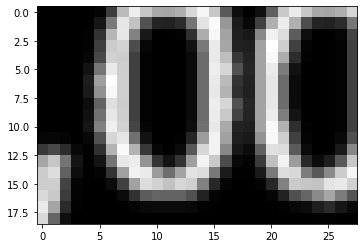

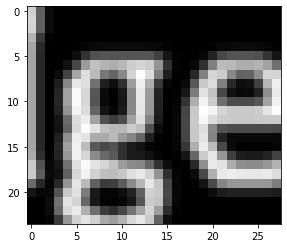

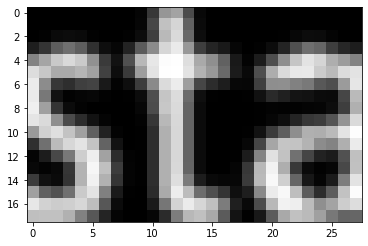

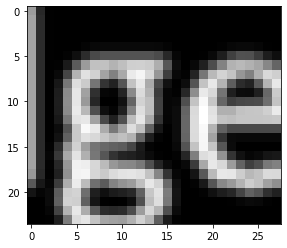

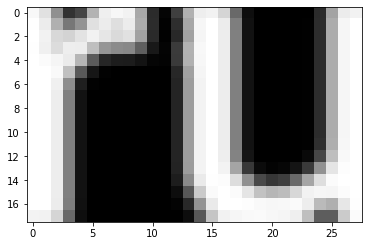

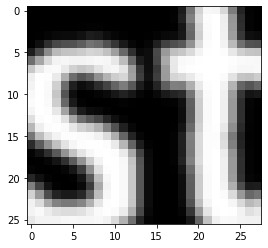

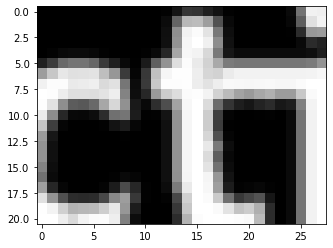

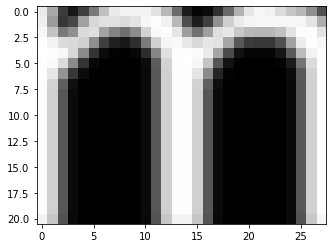

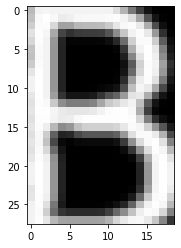

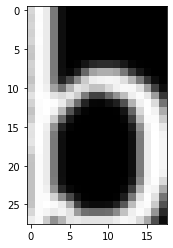

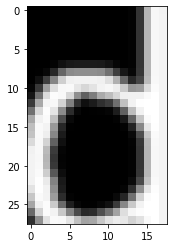

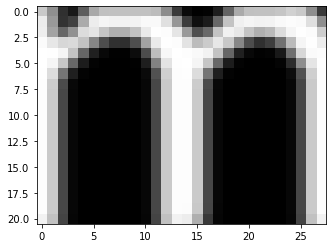

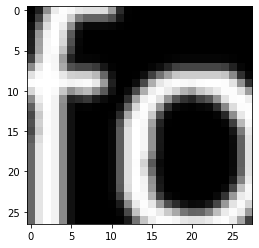

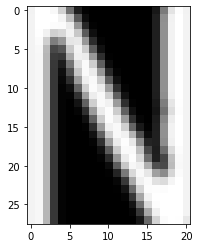

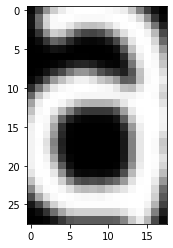

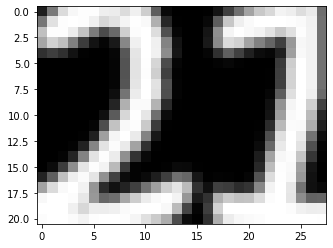

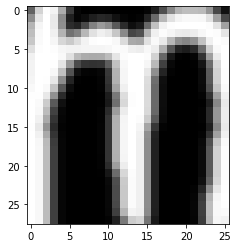

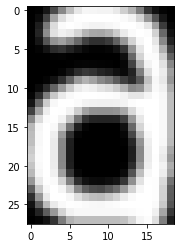

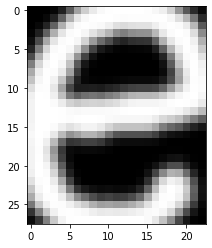

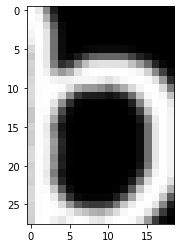

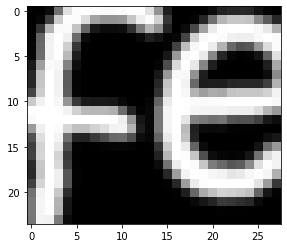

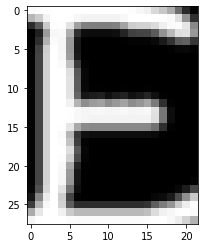

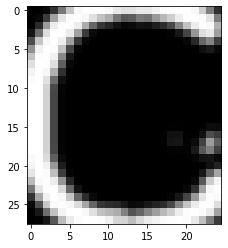

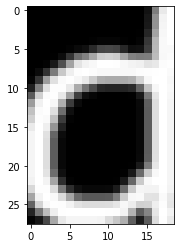

In [8]:
group_stage = []
for r in rects:
    cropped = tf.image.crop_to_bounding_box(
        blur.reshape(*blur.shape, 1), r[1], r[0], r[3] - r[1], r[2] - r[0]
    )
    cropped = tf.image.central_crop(
        cropped, 0.8
    )
    resized = tf.image.resize(
        cropped, (28,28), method=tf.image.ResizeMethod.BILINEAR, preserve_aspect_ratio=True
    )
    
    if len(np.nonzero(resized)[0]) < 3: continue
    
    plt.imshow(resized, cmap="gray")
    plt.show()
    group_stage.append(resized)

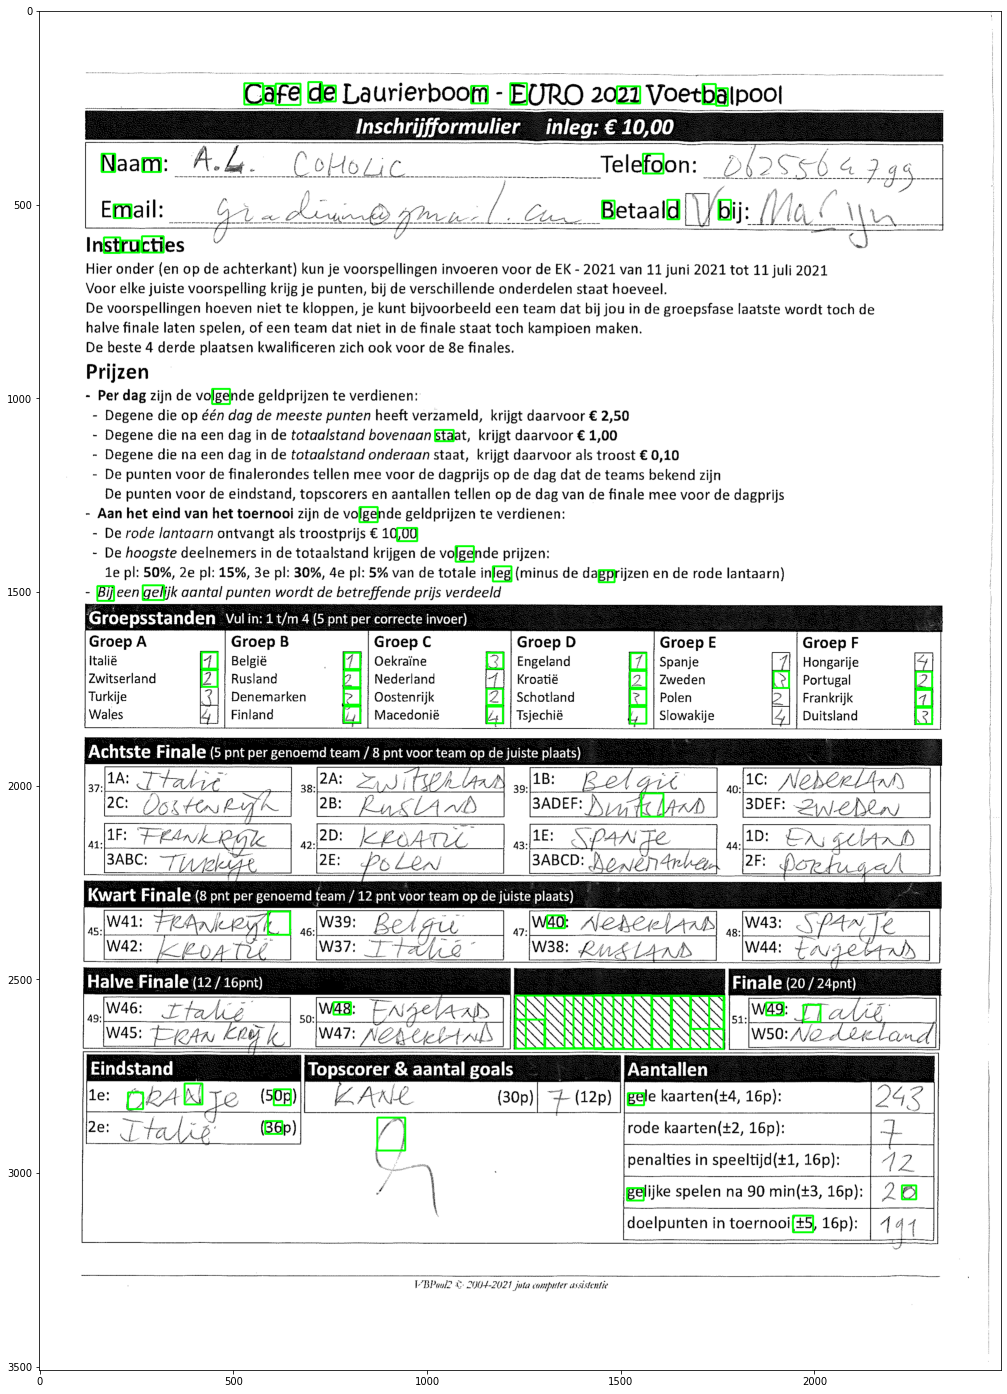

TypeError: cannot unpack non-iterable NoneType object

In [9]:
plt.figure(figsize=(25, 25))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
data = np.array([utils.zoom_to_bounds(img_array) for img_array in group_stage])
predictions = probability_model(data) * 100
for i, d in enumerate(data):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(10, 5))
    ax1.imshow(d, cmap="gray")
    ax2.bar(x=range(0, 10), height=predictions[i], tick_label=range(0, 10))
    ax2.set(ylabel="certainty", ylim=(0, 100))
